In [2]:
from pathlib import Path

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import torch
from dotenv import find_dotenv
from numpy.typing import NDArray
from sklearn.decomposition import PCA

from nns.vae.dataset import COCOKeypointsDataset, IntermediateKeypoints
from nns.vae.net import VAENet

plt.rcParams["text.usetex"] = True
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.left"] = False
plt.rcParams["axes.spines.bottom"] = False

plt.style.use("seaborn-v0_8-whitegrid")

root = Path(find_dotenv(raise_error_if_not_found=True)).parent.absolute()
checkpoints = root.joinpath("src", "nns", "vae", "checkpoints")

assert checkpoints.exists()


In [2]:
train_data_root = "~/Documents/Datasets/COCO/annotations_trainval2017/annotations/person_keypoints_train2017.json"
train_dataset = COCOKeypointsDataset(train_data_root, min_keypoints=10, max_kpts_to_mask=5)

poses = np.vstack(list(sample["origin_kpts"].flatten() for sample in train_dataset))
print("Dataset Size:", poses.shape)

Dataset Size: (88141, 28)


In [3]:
pca = PCA(n_components=0.95)
pca.fit(poses)

print("Explained Variance:", pca.explained_variance_ratio_.sum())
print("Num Components:", pca.n_components_)

Explained Variance: 0.9551069
Num Components: 14


Explained Variance: 0.5468735


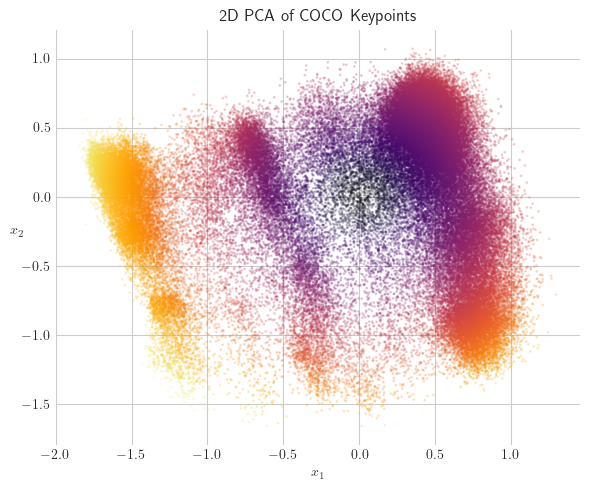

In [4]:
pca2d = PCA(n_components=2)
poses2d = pca2d.fit_transform(poses)
print("Explained Variance:", pca2d.explained_variance_ratio_.sum())

plt.figure(figsize=(6, 5), tight_layout=True)
plt.scatter(
    poses2d[:, 0],
    poses2d[:, 1],
    s=1,
    alpha=0.2,
    cmap="inferno",
    c=np.hypot(poses2d[:, 0], poses2d[:, 1]),
)
plt.title("2D PCA of COCO Keypoints")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$", rotation=0)
plt.show()

In [5]:
model = VAENet(input_shape=(14, 2), latent_features=16, hidden_units=[32, 64, 96])
model.load_state_dict(torch.load(checkpoints.joinpath("vae.pt"), weights_only=True))
model.eval()

loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)

_accumulated_embeddings = list()
_accumulated_means = list()
_accumulated_logvars = list()
_accumulated_poses = list()

with torch.inference_mode():
    for batch in loader:
        masked = batch["masked_kpts"]

        z = torch.flatten(masked, start_dim=1)
        z = model.encoder(z)
        z, mu, logvar = model.sampler(z)

        _accumulated_embeddings.append(z.numpy())
        _accumulated_means.append(mu.numpy())
        _accumulated_logvars.append(logvar.numpy())

        z = model.decoder(z)
        z = z.reshape(-1, 14, 2)

        _accumulated_poses.append(z.numpy())

accumulated_embeddings = np.vstack(_accumulated_embeddings).reshape(-1, 16)
accumulated_means = np.vstack(_accumulated_means).reshape(-1, 16)
accumulated_logvars = np.vstack(_accumulated_logvars).reshape(-1, 16)
accumulated_poses = np.vstack(_accumulated_poses).reshape(-1, 28)

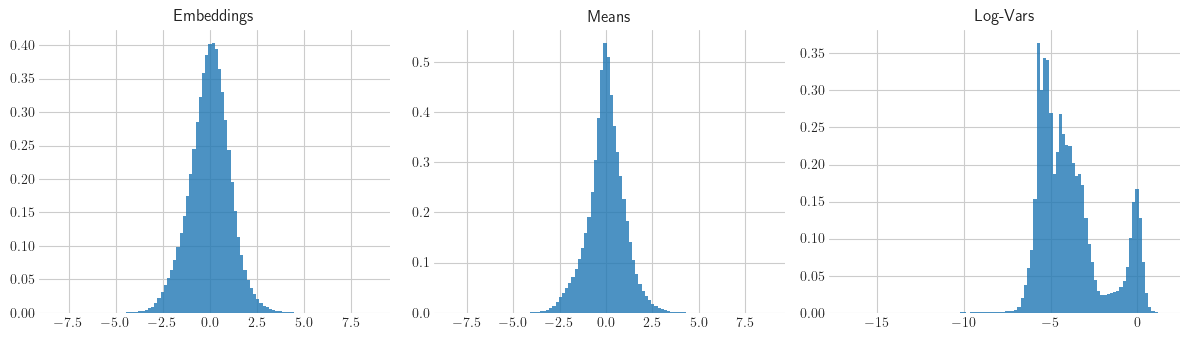

In [6]:
plt.figure(figsize=(12, 3.5), tight_layout=True)
plt.subplot(131)
plt.hist(accumulated_embeddings.flatten(), bins=100, density=True, alpha=0.8)
plt.title("Embeddings")
plt.subplot(132)
plt.hist(accumulated_means.flatten(), bins=100, density=True, alpha=0.8)
plt.title("Means")
plt.subplot(133)
plt.hist(accumulated_logvars.flatten(), bins=100, density=True, alpha=0.8)
plt.title("Log-Vars")
plt.show()

Explained Variance: 0.58612156


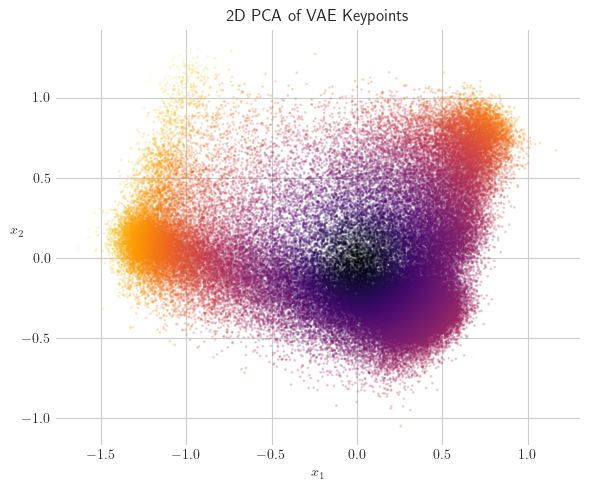

In [7]:
pca2d = PCA(n_components=2)
vae_poses2d = pca2d.fit_transform(accumulated_poses)
print("Explained Variance:", pca2d.explained_variance_ratio_.sum())

plt.figure(figsize=(6, 5), tight_layout=True)
plt.scatter(
    vae_poses2d[:, 0],
    vae_poses2d[:, 1],
    s=1,
    alpha=0.2,
    cmap="inferno",
    c=np.hypot(vae_poses2d[:, 0], vae_poses2d[:, 1]),
)
plt.title("2D PCA of VAE Keypoints")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$", rotation=0)
plt.show()

In [8]:
valid_data_root = "~/Documents/Datasets/COCO/annotations_trainval2017/annotations/person_keypoints_val2017.json"
valid_dataset = COCOKeypointsDataset(valid_data_root, min_keypoints=10, max_kpts_to_mask=5, with_image=True)

In [26]:
def draw_keypoints(img: NDArray, keypoints: NDArray, color: tuple[int, int, int]) -> None:
    for x, y, v in keypoints:
        if v == 0:
            continue
        cv.circle(img, (int(x), int(y)), 3, color, cv.FILLED, cv.LINE_AA)


def draw_skeleton(img: NDArray, keypoints: NDArray, color: tuple[int, int, int]) -> None:
    for kpt1, kpt2 in IntermediateKeypoints.LINKS:
        x1, y1, v1 = keypoints[kpt1 - 1]
        x2, y2, v2 = keypoints[kpt2 - 1]
        if v1 == 0 or v2 == 0:
            continue
        cv.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, 2, cv.LINE_AA)


def denorm_keypoints(keypoints: NDArray, bbox_xywh: NDArray) -> NDArray:
    return keypoints * bbox_xywh[2:] + bbox_xywh[:2]


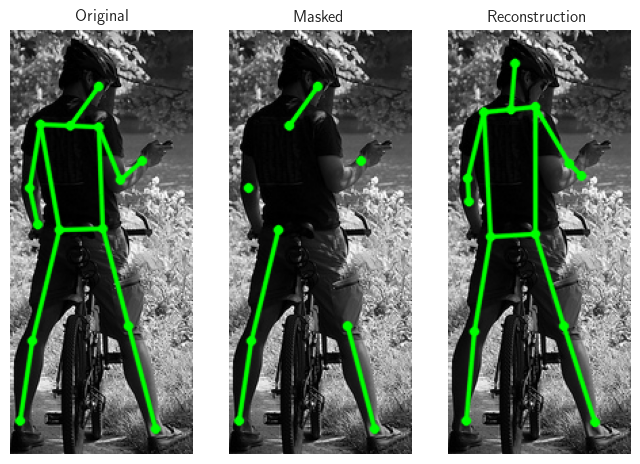

In [83]:
idx = 12
sample = valid_dataset[idx]

orig_kpts = sample["origin_kpts"]
orig_visb = sample["origin_visb"]
mask_kpts = sample["masked_kpts"]
mask_visb = sample["masked_visb"]
bbox_xywh = sample["bbox_xywh"]
img_file = sample["image_file"]

with torch.inference_mode():
    pred_kpts = model(torch.from_numpy(mask_kpts).unsqueeze(0)).squeeze().numpy()

orig_kpts = denorm_keypoints(orig_kpts, bbox_xywh)
mask_kpts = denorm_keypoints(mask_kpts, bbox_xywh)
pred_kpts = denorm_keypoints(pred_kpts, bbox_xywh)

img_root = Path("~/Documents/Datasets/COCO/val2017/val2017").expanduser()
img = cv.imread(str(img_root.joinpath(img_file)))
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

orig_kpts_visb = np.hstack((orig_kpts, orig_visb.reshape(-1, 1)))
mask_kpts_visb = np.hstack((mask_kpts, mask_visb.reshape(-1, 1)))
pred_kpts_visb = np.hstack((pred_kpts, orig_visb.reshape(-1, 1)))

orig_img = img.copy()
mask_img = img.copy()
pred_img = img.copy()

draw_skeleton(orig_img, orig_kpts_visb, (0, 255, 0))
draw_keypoints(orig_img, orig_kpts_visb, (0, 255, 0))

draw_skeleton(mask_img, mask_kpts_visb, (0, 255, 0))
draw_keypoints(mask_img, mask_kpts_visb, (0, 255, 0))

draw_skeleton(pred_img, pred_kpts_visb, (0, 255, 0))
draw_keypoints(pred_img, pred_kpts_visb, (0, 255, 0))

x1 = int(bbox_xywh[0])
y1 = int(bbox_xywh[1])
x2 = int(bbox_xywh[0] + bbox_xywh[2])
y2 = int(bbox_xywh[1] + bbox_xywh[3])

plt.figure(figsize=(8, 6))
plt.subplot(131)
plt.imshow(orig_img[y1:y2, x1:x2])
plt.axis("off")
plt.title("Original")
plt.subplot(132)
plt.imshow(mask_img[y1:y2, x1:x2])
plt.axis("off")
plt.title("Masked")
plt.subplot(133)
plt.imshow(pred_img[y1:y2, x1:x2])
plt.axis("off")
plt.title("Reconstruction")
plt.show()